In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import tensorflow as tf
import torch
from tensorflow import keras
from torch import nn
import random
import sklearn
import sklearn.model_selection
from torch.utils.data import DataLoader, TensorDataset, Dataset
import sklearn.preprocessing
import pandas as pd
from skimage import io
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

In [2]:
# Clear cuda cache
torch.cuda.empty_cache()

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

In [4]:
# Change to your root directory containing subdirectories for images and objects
os.chdir("D:/University/Projects/Computer Vision/AdvancedCompVisionProject/data")

In [5]:
ground_truth = pd.read_csv("ai-approach-2d-3d/Red blood cell/Microscopy_image_2D_features.csv")

In [6]:
ground_truth.loc[:,'cell_type'] = (ground_truth.loc[:,'filename'].
                                   str.replace('\.tif$', '', regex=True).
                                   str.replace('\d+', '', regex=True).
                                   str.replace('_*-', '', regex=True).
                                   str.replace('\.', '', regex=True).
                                   str.replace('^_*', '', regex=True)) 

In [7]:
ground_truth.head()

,filename,mean,std,gabor,glcm_diss,glcm_cor,cell_type
0,0.67_echinocyte_II000419.tif,59.658936,75.391372,246275.358608,28.218750,0.734313,echinocyte_II
1,D_multilobate_cells000730.tif,58.353271,84.593654,240885.505734,23.133475,0.804749,D_multilobate_cells
2,A_cell_clusters000648.tif,40.880127,58.600550,168755.406596,20.951801,0.737242,A_cell_clusters
3,0.00_discocyte000272.tif,102.040039,87.200715,421226.878792,41.918697,0.613713,discocyte
4,-0.33_stomatocyte_I000017.tif,20.345703,53.923155,83988.178591,20.654661,0.544581,stomatocyte_I


In [8]:
# Creating integer index of labels in dataframe
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(ground_truth['cell_type'])
ground_truth.loc[:,'label'] = label_encoder.transform(ground_truth['cell_type'])


In [9]:
ground_truth.head()

,filename,mean,std,gabor,glcm_diss,glcm_cor,cell_type,label
0,0.67_echinocyte_II000419.tif,59.658936,75.391372,246275.358608,28.218750,0.734313,echinocyte_II,7
1,D_multilobate_cells000730.tif,58.353271,84.593654,240885.505734,23.133475,0.804749,D_multilobate_cells,3
2,A_cell_clusters000648.tif,40.880127,58.600550,168755.406596,20.951801,0.737242,A_cell_clusters,0
3,0.00_discocyte000272.tif,102.040039,87.200715,421226.878792,41.918697,0.613713,discocyte,5
4,-0.33_stomatocyte_I000017.tif,20.345703,53.923155,83988.178591,20.654661,0.544581,stomatocyte_I,10


In [10]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        #self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        try:
            img = io.imread(f'image/{self.dataset[idx, 0]}')
            img = Image.fromarray(img)
        except IOError:
            print(f"Error opening image {self.dataset[idx, 0]}")
            return 0, 0
        try:
            obj = io.imread(f'obj/{self.dataset[idx, 0]}')
            #obj = Image.fromarray(obj)
        except IOError:
            print(f"Error opening object {self.dataset[idx, 0]}")
            return 0, 0
        label = int(self.dataset[idx, -1])
        if self.transform:
            img = self.transform(img)
        return img, obj, label

In [11]:
transform = transforms.Compose([
    # transforms.Resize((64, 64)),
    transforms.CenterCrop(64),
    transforms.ToTensor()
])

In [ ]:
# sample_dataset = ImageDataset(ground_truth.values, transform=transform)
# sample_dataloader = DataLoader(sample_dataset, batch_size=4, shuffle=True)

In [12]:
num_classes = pd.Categorical(ground_truth['cell_type']).categories.shape[0]
num_classes

12

In [13]:
train_rows, val_rows = sklearn.model_selection.train_test_split(ground_truth, test_size=0.2)

In [14]:
train_dataset = ImageDataset(train_rows.values, transform=transform)
val_dataset = ImageDataset(val_rows.values, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [15]:
img, obj, label = next(iter(train_dataloader))
print(img.shape, obj.shape, label.shape)

torch.Size([8, 1, 64, 64]) torch.Size([8, 64, 64, 64]) torch.Size([8])


##### Classification Problem

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1)
        #self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bnorm3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bnorm4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.pool(F.leaky_relu(self.bnorm1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bnorm2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bnorm3(self.conv3(x))))
        x= self.pool(F.leaky_relu(self.bnorm4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.conv5(x)))
        # x = self.pool(F.leaky_relu(self.conv5(x)))
        x = x.view(-1, 512)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.view(batch_size, -1)
        return x

In [ ]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta= 0.1):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_val_acc = 0

    def early_stop(self, acc):
        if acc > self.max_val_acc + self.min_delta:
            self.max_val_acc = acc
            self.counter = 0

        elif acc <= (self.max_val_acc + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train_an_epoch(model, data_loader, criterion, optimizer, scheduler=None):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(data_loader):
        x_batch, obj_batch, y_batch = data
        x_batch = x_batch.to(DEVICE).float()
        y_batch = y_batch.to(DEVICE).long()
        optimizer.zero_grad()
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    return running_loss / len(data_loader)

In [ ]:
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, obj, labels = data
            images = images.to(DEVICE).float()
            labels = labels.to(DEVICE).long()
            outputs = model(images)
            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
classification_model = CNNModel().to(DEVICE)
NUM_EPOCHS = 25
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classification_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # Accounts for L2 normalization
writer = SummaryWriter()
earlystopper = EarlyStopper(patience=3, min_delta=0.001)
validation_accuracy = 0

for epoch in range(NUM_EPOCHS):
    # Training phase
    train_loss = train_an_epoch(classification_model, train_dataloader, criterion, optimizer, scheduler)
    if earlystopper.early_stop(validation_accuracy):
        print(f'Early stopping at epoch {epoch+1}')
        print('=====================')
        print(f'validation_accuracy: {validation_accuracy:.6f}')
        break
    writer.add_scalar('Loss/train', train_loss, epoch)
    training_accuracy = calculate_accuracy(classification_model, train_dataloader)
    writer.add_scalar('Accuracy/train', training_accuracy, epoch)
    validation_accuracy = calculate_accuracy(classification_model, val_dataloader)
    writer.add_scalar('Accuracy/validation', validation_accuracy, epoch)
    if epoch % 2 == 0:
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print('=====================')
        print(f'Training Average Loss: {train_loss:.6f}')
        print(f'Training Accuracy: {training_accuracy:.6f}')
        print(f'Validation Accuracy: {validation_accuracy:.6f}')
    writer.flush()
writer.close()


# 3D Conv

In [ ]:
class CNNModel3d(nn.Module):
    def __init__(self):
        super(CNNModel3d, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool3d(3, stride=2)
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        #self.bnorm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv3d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(512, 2048)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(2048, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, 64, 64, 64)
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x= self.pool(F.leaky_relu(self.conv4(x)))
        x = self.pool(F.leaky_relu(self.conv5(x)))
        x = x.view(-1, 512)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.view(batch_size, -1)
        return x

In [ ]:
def train_an_epoch3d(model, data_loader, criterion, optimizer, scheduler=None):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(data_loader):
        x_batch, obj_batch, y_batch = data
        y_batch = y_batch.to(DEVICE).long()
        obj_batch = obj_batch.to(DEVICE).float()
        optimizer.zero_grad()
        y_hat = model(obj_batch)
        loss = criterion(y_hat, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    return running_loss / len(data_loader)

In [ ]:
def calculate_accuracy3d(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, obj, labels = data
            obj = obj.to(DEVICE).float()
            labels = labels.to(DEVICE).long()
            outputs = model(obj)
            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
conv3d_model = CNNModel3d().to(DEVICE)
NUM_EPOCHS = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv3d_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
writer = SummaryWriter()
earlystopper = EarlyStopper(patience=3, min_delta=0.01)

for epoch in range(NUM_EPOCHS):
    # Training phase
    train_loss = train_an_epoch3d(conv3d_model, train_dataloader, criterion, optimizer, scheduler)
    if earlystopper.early_stop(validation_accuracy):
        print(f'Early stopping at epoch {epoch+1}')
        print('=====================')
        print(f'validation_accuracy: {validation_accuracy:.6f}')
        break
    writer.add_scalar('Loss/train', train_loss, epoch)
    training_accuracy = calculate_accuracy3d(conv3d_model, train_dataloader)
    writer.add_scalar('Accuracy/train', training_accuracy, epoch)
    validation_accuracy = calculate_accuracy3d(conv3d_model, val_dataloader)
    writer.add_scalar('Accuracy/validation', validation_accuracy, epoch)
    if epoch % 2 == 0:
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print('=====================')
        print(f'Training Average Loss: {train_loss:.6f}')
        print(f'Training Accuracy: {training_accuracy:.6f}')
        print(f'Validation Accuracy: {validation_accuracy:.6f}')
    writer.flush()
writer.close()


# Seq 2 Seq for 3d object generation

In [ ]:
# class ImageEncoder(nn.Module):
#     def __init__(self, num_layers = 4):
#         super(ImageEncoder, self).__init__()
#         self.layer_dict = nn.ModuleDict()
#         self.num_layers = num_layers
#         input_layers = 1
#         for i in range(num_layers):
#             if i <= 6:
#                 output_layers = 32*(2**i)
#             else:
#                 output_layers = 32*(2**6)
#             self.layer_dict[f'conv{i+1}'] = nn.Conv2d(input_layers, output_layers, kernel_size=3, padding=1)
#             self.layer_dict[f'bnorm{i+1}'] = nn.BatchNorm2d(output_layers)
#             input_layers = output_layers
    
#     def forward(self, x):
#         conv_outputs = []
#         pool_outputs = []
#         for i in range(self.num_layers):
#             x_conv = F.leaky_relu(self.layer_dict[f'bnorm{i+1}'](self.layer_dict[f'conv{i+1}'](x)))
#             if i < 5:
#                 x_pool = F.max_pool2d(x_conv, 3, stride=2)
#             # else:
#             #     x_pool = F.max_pool2d(x_conv, 2, stride=1)
#             if i < self.num_layers - 1:
#                 conv_outputs.append(x_conv)
#             pool_outputs.append(x_pool)
#             x = x_pool
#         # print("encoder successful")
#         return conv_outputs, pool_outputs

In [19]:
NUM_LAYERS = 5

In [20]:
class reduce_dimensions(nn.Module):
    def __init__(self, num_layers = 4):
        dimension = 32*(2**(num_layers-1)) + 1
        super(reduce_dimensions, self).__init__()
        self.conv1 = nn.ConvTranspose3d(dimension, 1, kernel_size=1, padding=0)
    
    def forward(self, x):
        x = self.conv1(x)
        return x.squeeze(1)

dim_red = reduce_dimensions(NUM_LAYERS)

In [21]:
class ImageEncoder(nn.Module):
    def __init__(self, num_layers = 4):
        super(ImageEncoder, self).__init__()
        self.layer_dict = nn.ModuleDict()
        self.num_layers = num_layers
        input_layers = 1
        for i in range(num_layers):
            output_layers = 32*(2**i)
            self.layer_dict[f'conv{i+1}'] = nn.Conv2d(input_layers, output_layers, kernel_size=3, padding=1)
            self.layer_dict[f'bnorm{i+1}'] = nn.BatchNorm2d(output_layers)
            input_layers = output_layers
    
    def forward(self, x):
        conv_outputs = []
        pool_outputs = []
        for i in range(self.num_layers):
            x_conv = F.leaky_relu(self.layer_dict[f'bnorm{i+1}'](self.layer_dict[f'conv{i+1}'](x)))
            x_pool = F.max_pool2d(x_conv, 3, stride=2)
            conv_outputs.append(x_conv)
            pool_outputs.append(x_pool)
            x = x_pool
        return conv_outputs, pool_outputs

In [22]:
class ObjectDecoder(nn.Module):
    def __init__(self, encoder, num_layers):
        super(ObjectDecoder, self).__init__()
        self.layer_dict = nn.ModuleDict()
        self.encoder = encoder
        self.num_layers = num_layers
        for i in range(num_layers):
            if i == num_layers - 1:
                output_layers = 1
            else:    
                output_layers = 32*(2**(num_layers-i-2))
            self.layer_dict[f'convtrans{i+1}'] = nn.ConvTranspose3d(32*(2**(num_layers-i-1)), output_layers, kernel_size=3, padding=1)
    
    def forward(self, x):
        encoder_conv, encoder_pool = self.encoder(x)
        final_encoder = encoder_pool.pop()
        x = final_encoder
        x = x.unsqueeze(-1)
        for i in range(self.num_layers):
            x = self.layer_dict[f'convtrans{i+1}'](x)
            x_enc = encoder_conv[self.num_layers - i-2].unsqueeze(-1)
            spatial_size = x_enc.size()[2:]
            x_resized = F.interpolate(x, size=spatial_size, mode='trilinear', align_corners=False)
            x_concat = torch.cat((x_resized, x_enc), dim=1)
            x_out = F.leaky_relu(x_concat)
        return x_out
    

In [23]:
class UNet3D(nn.Module):
    def __init__(self, num_layers = 4):
        super(UNet3D, self).__init__()
        self.num_layers = num_layers
        self.encoder = ImageEncoder(num_layers=self.num_layers)
        self.decoder = ObjectDecoder(self.encoder, num_layers=self.num_layers)

    def forward(self, x, obj_spatial_size=(64, 64, 64)):
        x_decoded = self.decoder(x)
        x_interpolated = F.interpolate(x_decoded, size=obj_spatial_size, mode='trilinear', align_corners=False)
        x_out = dim_red(x_interpolated)
        return x_out

In [24]:
def train_an_epoch_unet(model, data_loader, criterion, optimizer, scheduler=None):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(data_loader):
        x_batch, obj_batch, y_batch = data
        x_batch = x_batch.to(DEVICE).float()
        obj_batch = (obj_batch.to(DEVICE).float() > 5).float()
        optimizer.zero_grad()
        y_hat = model(x_batch)
        # obj_spatial_size = obj_batch.size()[1:]
        # y_hat = F.interpolate(y_hat, size=obj_spatial_size, mode='trilinear', align_corners=False)
        # y_hat = dim_red(y_hat)
        loss = criterion(y_hat.float(), obj_batch.float())
        if i % 10 == 0:
            print(f'Loss at batch {i}: {loss.item()}')
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    return running_loss / len(data_loader)

In [ ]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weight=None):
        super(WeightedMSELoss, self).__init__()
        self.weight = weight

    def forward(self, input, target):
        if self.weight is not None:
            loss = self.weight * (input - target) ** 2
        else:
            loss = (input - target) ** 2
        return loss.mean()

# Example weight tensor
# Assuming weight for class 0 is 1 and for class 1 is 10
weight = torch.tensor([1.0, 10.0]).to(DEVICE)

# Use the custom weighted loss
criterion = WeightedMSELoss(weight=weight)


Loss at batch 0: 1.6928772926330566
Loss at batch 10: 0.7176415920257568
Loss at batch 20: 0.7091761827468872
Loss at batch 30: 0.6855453252792358
Loss at batch 40: 0.5201625823974609
Loss at batch 50: 0.7118244171142578
Loss at batch 60: 0.546603798866272
Loss at batch 70: 0.5090702772140503
Loss at batch 80: 0.488471657037735
Epoch 1/10
Training Average Loss: 0.617759
torch.Size([8, 64, 64, 64])


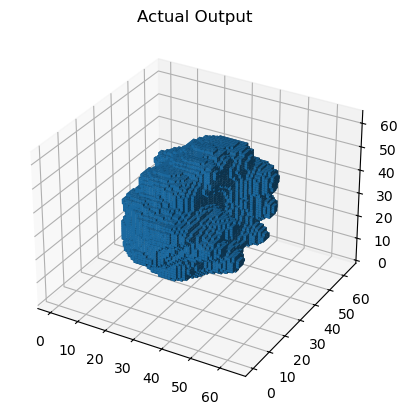

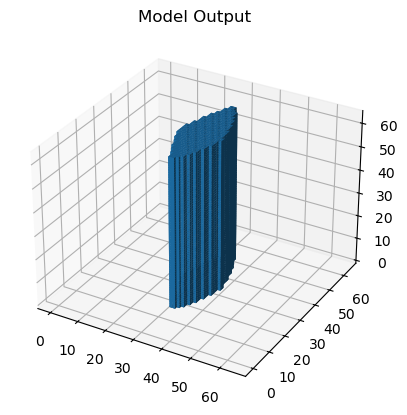

Loss at batch 0: 0.46265044808387756
Loss at batch 10: 0.5105921626091003
Loss at batch 20: 0.4106518626213074
Loss at batch 30: 0.49009397625923157
Loss at batch 40: 0.43745318055152893
Loss at batch 50: 0.4795893430709839
Loss at batch 60: 0.47103407979011536
Loss at batch 70: 0.4687001705169678
Loss at batch 80: 0.4733268916606903
Epoch 2/10
Training Average Loss: 0.456522
torch.Size([8, 64, 64, 64])


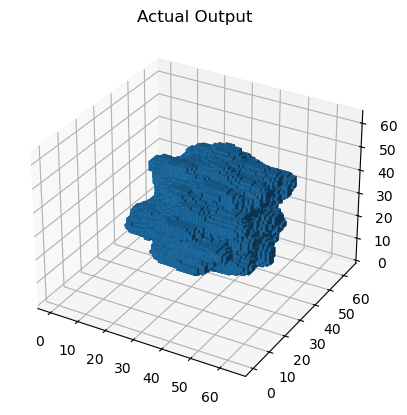

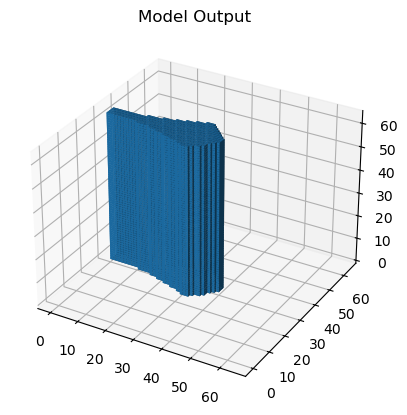

Loss at batch 0: 0.532896101474762
Loss at batch 10: 0.45107632875442505
Loss at batch 20: 0.44166338443756104
Loss at batch 30: 0.373466432094574
Loss at batch 40: 0.4329187870025635
Loss at batch 50: 0.4353843331336975
Loss at batch 60: 0.40847301483154297
Loss at batch 70: 0.42796799540519714
Loss at batch 80: 0.37989485263824463
Epoch 3/10
Training Average Loss: 0.408882
torch.Size([8, 64, 64, 64])


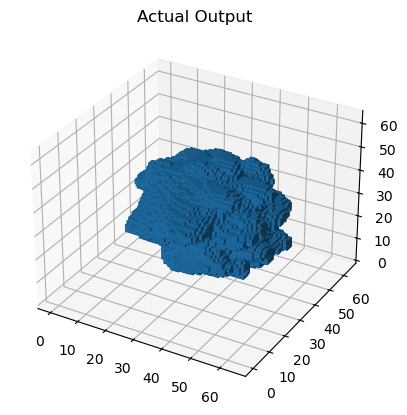

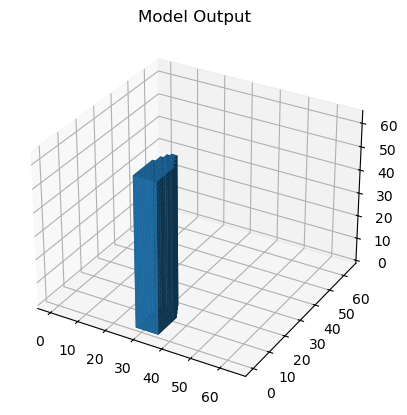

Loss at batch 0: 0.4317011833190918
Loss at batch 10: 0.4691448509693146
Loss at batch 20: 0.36204835772514343
Loss at batch 30: 0.33473503589630127
Loss at batch 40: 0.3997485041618347
Loss at batch 50: 0.3738780617713928
Loss at batch 60: 0.5055239796638489
Loss at batch 70: 0.42137086391448975
Loss at batch 80: 0.3520732522010803
Epoch 4/10
Training Average Loss: 0.378885
torch.Size([8, 64, 64, 64])


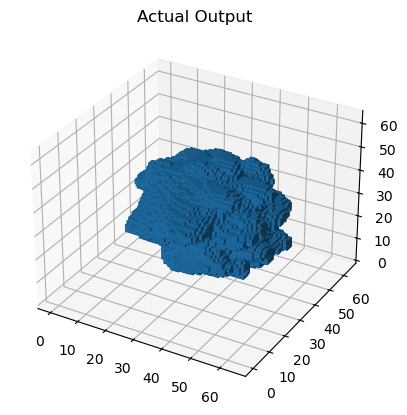

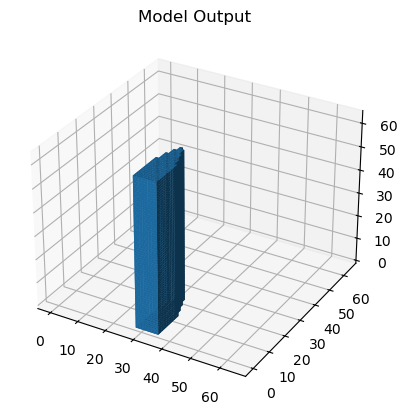

Loss at batch 0: 0.41744542121887207
Loss at batch 10: 0.3557761609554291
Loss at batch 20: 0.4320640563964844
Loss at batch 30: 0.3605665862560272
Loss at batch 40: 0.3351214528083801
Loss at batch 50: 0.38970208168029785
Loss at batch 60: 0.35637930035591125
Loss at batch 70: 0.35851916670799255
Loss at batch 80: 0.33214592933654785
Epoch 5/10
Training Average Loss: 0.362142
torch.Size([8, 64, 64, 64])


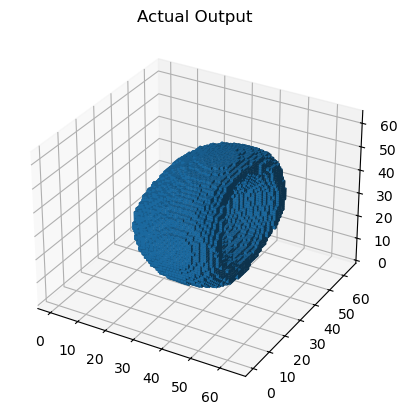

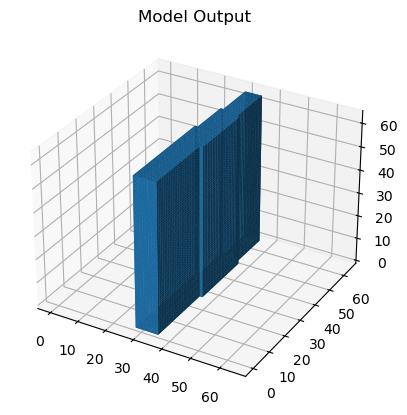

Loss at batch 0: 0.39450502395629883
Loss at batch 10: 0.3215027451515198
Loss at batch 20: 0.3831382989883423
Loss at batch 30: 0.3475853502750397
Loss at batch 40: 0.3062402904033661
Loss at batch 50: 0.3785150647163391
Loss at batch 60: 0.3329867720603943
Loss at batch 70: 0.31554144620895386
Loss at batch 80: 0.37550684809684753
Epoch 6/10
Training Average Loss: 0.343460
torch.Size([8, 64, 64, 64])


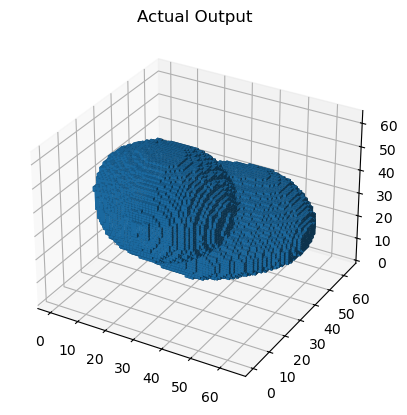

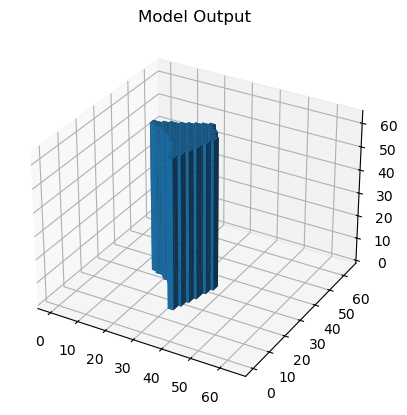

Loss at batch 0: 0.3306998610496521
Loss at batch 10: 0.35810986161231995
Loss at batch 20: 0.31005626916885376
Loss at batch 30: 0.37102454900741577
Loss at batch 40: 0.3672594428062439
Loss at batch 50: 0.3449908494949341
Loss at batch 60: 0.3512096405029297
Loss at batch 70: 0.36776816844940186
Loss at batch 80: 0.37240055203437805
Epoch 7/10
Training Average Loss: 0.342531
torch.Size([8, 64, 64, 64])


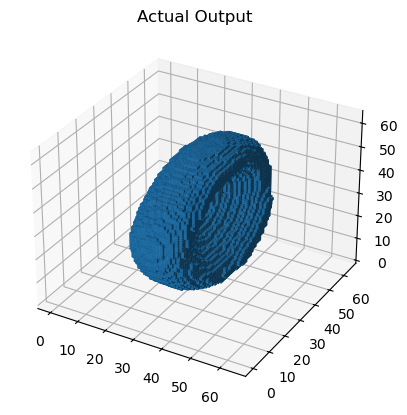

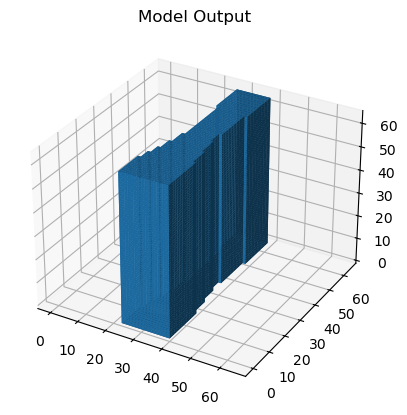

Loss at batch 0: 0.4294080138206482
Loss at batch 10: 0.3396243453025818
Loss at batch 20: 0.2999967038631439
Loss at batch 30: 0.3090329170227051
Loss at batch 40: 0.3478460907936096
Loss at batch 50: 0.3476439416408539
Loss at batch 60: 0.3203880190849304
Loss at batch 70: 0.3412923812866211
Loss at batch 80: 0.3684035539627075
Epoch 8/10
Training Average Loss: 0.342138
torch.Size([8, 64, 64, 64])


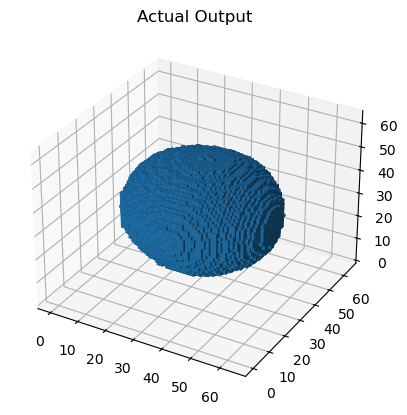

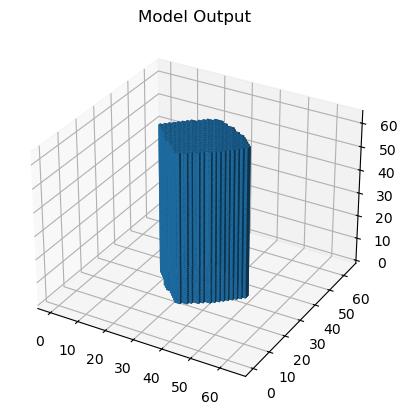

Loss at batch 0: 0.29876086115837097
Loss at batch 10: 0.3691258728504181
Loss at batch 20: 0.3879268765449524
Loss at batch 30: 0.29428625106811523
Loss at batch 40: 0.33544015884399414
Loss at batch 50: 0.27253949642181396
Loss at batch 60: 0.36414670944213867
Loss at batch 70: 0.30807608366012573
Loss at batch 80: 0.3433343172073364
Epoch 9/10
Training Average Loss: 0.339110
torch.Size([8, 64, 64, 64])


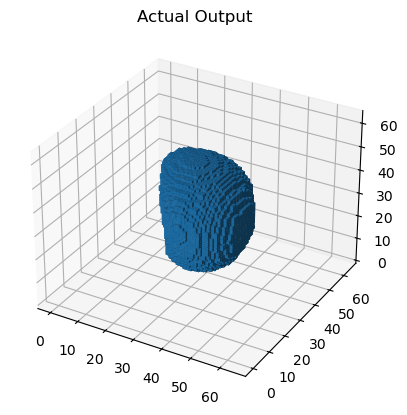

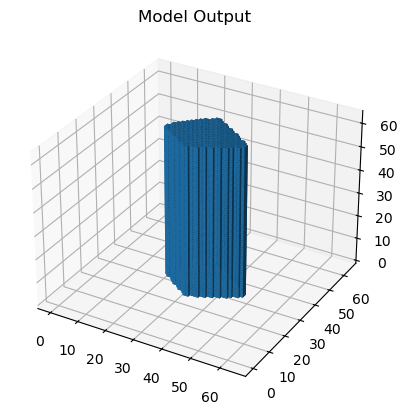

Loss at batch 0: 0.3106611967086792
Loss at batch 10: 0.3237382173538208
Loss at batch 20: 0.3240334689617157
Loss at batch 30: 0.32549959421157837
Loss at batch 40: 0.29782965779304504
Loss at batch 50: 0.33486443758010864
Loss at batch 60: 0.36022740602493286
Loss at batch 70: 0.34734106063842773
Loss at batch 80: 0.3227780759334564
Epoch 10/10
Training Average Loss: 0.337450
torch.Size([8, 64, 64, 64])


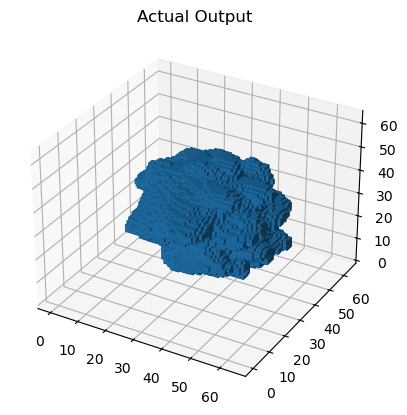

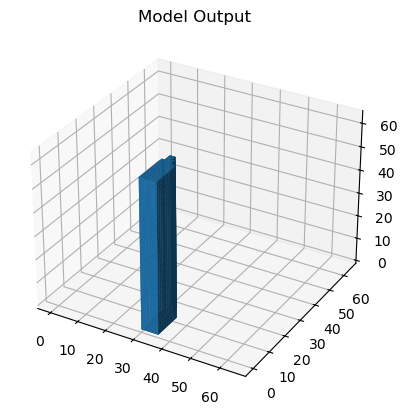

In [29]:
# Training the UNet3D model
NUM_LAYERS = 5
unet3d_model = UNet3D(num_layers=NUM_LAYERS).to(DEVICE)
dim_red = reduce_dimensions(num_layers=NUM_LAYERS).to(DEVICE)
NUM_EPOCHS = 10
criterion = nn.BCEWithLogitsLoss()
# weight = torch.tensor([1.0, 10.0]).to(DEVICE)
# criterion = WeightedMSELoss(weight=weight)
optimizer = optim.Adam(unet3d_model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
writer = SummaryWriter()
#earlystopper = EarlyStopper(patience=3, min_delta=0.001)

for epoch in range(NUM_EPOCHS):
    # Training phase
    train_loss = train_an_epoch_unet(unet3d_model, train_dataloader, criterion, optimizer, scheduler)
    writer.add_scalar('Loss/train', train_loss, epoch)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print('=====================')
    print(f'Training Average Loss: {train_loss:.6f}')
    # print the output of the model for the same input image from validation set
    sample_image, actual_output,_ = next(iter(val_dataloader))
    
    # Move the input to the appropriate device
    sample_image = sample_image.to(DEVICE).float()
    
    # Model prediction
    sample_output = unet3d_model(sample_image)
    print(sample_output.shape)
    sample_output = sample_output.detach().cpu().numpy()
    actual_output = actual_output.numpy()
    
    # Visualize the actual 3D output
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(actual_output[0] > 0.5)  # Visualizing the first sample in the batch
    plt.title('Actual Output')
    plt.show()
    
    # Visualize the model's 3D output
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(sample_output[0] > 0.5)  # Visualizing the first sample in the batch
    plt.title('Model Output')
    plt.show()
    
    writer.flush()
writer.close()